# World Bank Dataset Exercise

**About the Source of the Dataset:**

_World Bank Projects & Operations provides access to basic information on all of the World Bank's lending projects from 1947 to the present. The dataset includes basic information such as the project title, task manager, country, project id, sector, themes, commitment amount, product line, and financing. It also provides links to publicly disclosed online documents._

**Tasks**

1. Find the 10 countries with most projects
2. Find the top 10 major project themes (using column 'mjtheme_namecode')
3. In 2. above you will notice that some entries have only the code and the name is missing. Create a dataframe with the missing names filled in.

# Initial Exploration and Cleaning

In this first step, I import some basic packages, reduce the columns to the ones necessary for our analysis, perform a few type conversions and explore the boundaries of the dataset.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize

In [2]:
# Read in the json file and print out some descriptive info to better understand what the dataset entails
worldbank_df = pd.read_json('data/world_bank_projects.json',convert_dates=['boardapprovaldate','closingdate'])
print(worldbank_df.columns)

Index(['_id', 'approvalfy', 'board_approval_month', 'boardapprovaldate',
       'borrower', 'closingdate', 'country_namecode', 'countrycode',
       'countryname', 'countryshortname', 'docty', 'envassesmentcategorycode',
       'grantamt', 'ibrdcommamt', 'id', 'idacommamt', 'impagency',
       'lendinginstr', 'lendinginstrtype', 'lendprojectcost',
       'majorsector_percent', 'mjsector_namecode', 'mjtheme',
       'mjtheme_namecode', 'mjthemecode', 'prodline', 'prodlinetext',
       'productlinetype', 'project_abstract', 'project_name', 'projectdocs',
       'projectfinancialtype', 'projectstatusdisplay', 'regionname', 'sector',
       'sector1', 'sector2', 'sector3', 'sector4', 'sector_namecode',
       'sectorcode', 'source', 'status', 'supplementprojectflg', 'theme1',
       'theme_namecode', 'themecode', 'totalamt', 'totalcommamt', 'url'],
      dtype='object')


In [3]:
# Narrow View to Columns relevant to this analysis
worldbank_df = worldbank_df.loc[:,['_id','boardapprovaldate','closingdate','countrycode',
                                   'countryname','regionname','mjtheme_namecode']]
worldbank_df.info()
worldbank_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
_id                  500 non-null object
boardapprovaldate    500 non-null datetime64[ns]
closingdate          370 non-null datetime64[ns]
countrycode          500 non-null object
countryname          500 non-null object
regionname           500 non-null object
mjtheme_namecode     500 non-null object
dtypes: datetime64[ns](2), object(5)
memory usage: 27.4+ KB


,_id,boardapprovaldate,closingdate,countrycode,countryname,regionname,mjtheme_namecode
0,{'$oid': '52b213b38594d8a2be17c780'},2013-11-12,2018-07-07,ET,Federal Democratic Republic of Ethiopia,Africa,"[{'code': '8', 'name': 'Human development'}, {..."
1,{'$oid': '52b213b38594d8a2be17c781'},2013-11-04,NaT,TN,Republic of Tunisia,Middle East and North Africa,"[{'code': '1', 'name': 'Economic management'},..."
2,{'$oid': '52b213b38594d8a2be17c782'},2013-11-01,NaT,TV,Tuvalu,East Asia and Pacific,"[{'code': '5', 'name': 'Trade and integration'..."
3,{'$oid': '52b213b38594d8a2be17c783'},2013-10-31,NaT,RY,Republic of Yemen,Middle East and North Africa,"[{'code': '7', 'name': 'Social dev/gender/incl..."
4,{'$oid': '52b213b38594d8a2be17c784'},2013-10-31,2019-04-30,LS,Kingdom of Lesotho,Africa,"[{'code': '5', 'name': 'Trade and integration'..."


In [4]:
# Board Approval Dates
print(worldbank_df['boardapprovaldate'].sort_values().head(1))
print(worldbank_df['boardapprovaldate'].sort_values().tail(1))

# Closing Dates
print(worldbank_df['closingdate'].dropna().sort_values().head(1))
print(worldbank_df['closingdate'].dropna().sort_values().tail(1))

499   2012-08-02
Name: boardapprovaldate, dtype: datetime64[ns]
0   2013-11-12
Name: boardapprovaldate, dtype: datetime64[ns]
145   2007-12-31
Name: closingdate, dtype: datetime64[ns]
100   2021-12-31
Name: closingdate, dtype: datetime64[ns]


As this is a subset of the original dataset and the source link doesn't work we'll have to make a few assumptions. The column 'closingdate' includes a number of null values, for the purpose of this analysis we'll assume that these projects have not been finalized at this point and lending has not happened.

This seems like a promising dataset of the World Bank covering projects approved by the board stretching from August 2012 to November 2013 or projects with closing dates stretching from 2008 (last day in 2007) to 2022 (last day in 2021).

# Countries & Projects

In this first section we'll explore country-specific metrics, specifically the countries with the most projects. 

In [5]:
# Create a list of Country Names
countries_df = worldbank_df.loc[:,['countryname','countrycode','regionname']].drop_duplicates()
# Sort Countries by countrycode
countries_df = countries_df.sort_values(by='countrycode').set_index('countrycode')

# Check Countries DataFrame info
countries_df.info()

countries_df.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 118 entries, 1W to ZW
Data columns (total 2 columns):
countryname    118 non-null object
regionname     118 non-null object
dtypes: object(2)
memory usage: 2.8+ KB


,countryname,regionname
countrycode,,
1W,World,Other
3A,Africa,Africa
4E,East Asia and Pacific,East Asia and Pacific
4P,Pacific Islands,East Asia and Pacific
5M,Middle East and North Africa,Middle East and North Africa


In [6]:
# Number of Projects assigned to regions rather than countries
regions_codes = ['1W','3A','4E','4P','5M','7E','8S']
print('Number of Projects assigned to Regions ',len(worldbank_df.loc[worldbank_df['countrycode'].isin(regions_codes),:]))

# Remove Regions in countries_df and worldbank_df
worldbank_df_no_regions = worldbank_df.loc[~worldbank_df.loc[:,'countrycode'].isin(regions_codes),:].copy()
countries_df_no_regions = countries_df.loc[~countries_df.index.isin(regions_codes),:].copy()

print('Remaining Projects ',len(worldbank_df_no_regions))
print('Remaining Countries ', len(countries_df_no_regions))

Number of Projects assigned to Regions  25
Remaining Projects  475
Remaining Countries  111


In [7]:
# Percent of Member Countries (189 World Bank Member States) with lending projects
print('Percent of Member Countries with Projects ', round(len(countries_df_no_regions) / 189 * 100,2),'%')

Percent of Member Countries with Projects  58.73 %


The first exploration of the dataset shows that there is a total of 118 unique country codes in the data. We should note that there is a country code for each continent and the world. As these are rather regions than countries and due to a lacking description of how this data could be interpreted as countries, I've decided to remove the region columns as they only make up 25 of the 500 projects. 

This leaves us with 111 actual countries, which is significantly less then the number of recognized countries by the United Nations (195), if we take the number of countries that are members of the Worldbank (189) for comparison, that still leaves us with 71 countries that have no official lending project with the Worldbank for the respective dates. On the other hand almost 58.73% of Worldbank member countries have gotten approved for a lending project between Summer 2012 and Winter 2013.

In [8]:
# Group by Countries and Count projects
by_country = worldbank_df_no_regions.groupby('countrycode')['countrycode']
projects_df = by_country.count().sort_index().to_frame(name='projects')

# Concatenate Countries and Projects and sort by project count descending
countries_and_projects_df = pd.concat([countries_df_no_regions,projects_df],axis='columns').sort_values(by='projects', ascending=False)

# Show Top 10 Countries by Project Count
countries_and_projects_df.head(10)

,countryname,regionname,projects
countrycode,,,
CN,People's Republic of China,East Asia and Pacific,19
ID,Republic of Indonesia,East Asia and Pacific,19
VN,Socialist Republic of Vietnam,East Asia and Pacific,17
IN,Republic of India,South Asia,16
RY,Republic of Yemen,Middle East and North Africa,13
BD,People's Republic of Bangladesh,South Asia,12
NP,Nepal,South Asia,12
MA,Kingdom of Morocco,Middle East and North Africa,12
MZ,Republic of Mozambique,Africa,11


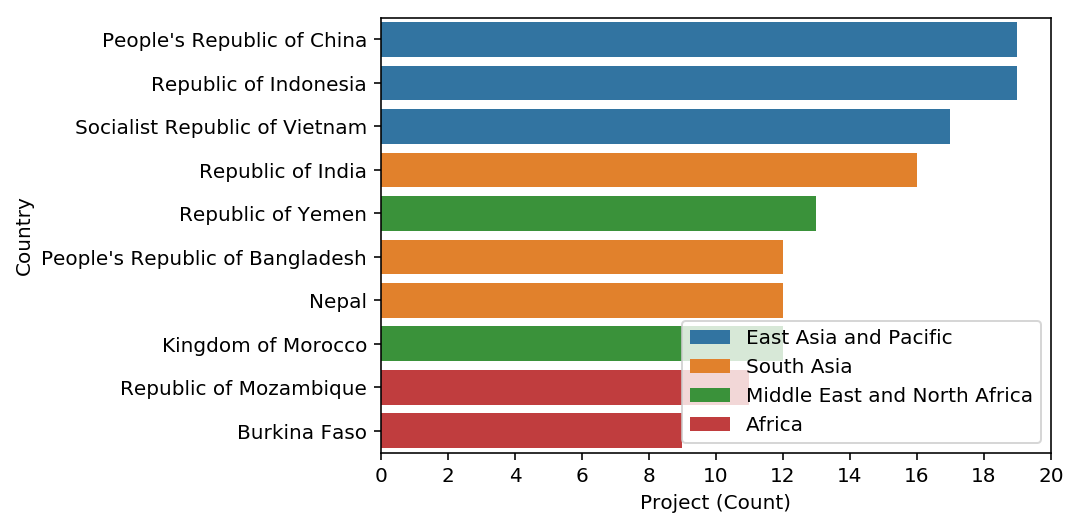

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


fig, ax = plt.subplots()
g = sns.barplot(data=countries_and_projects_df.iloc[:10,:],ax=ax,x='projects',y='countryname',hue='regionname',dodge=False)
plt.xticks(list(range(0,21,2)))
plt.xlabel('Project (Count)')
plt.ylabel('Country')
plt.legend(loc='lower right')

In [10]:
# Sum of Projects for Top 10 Countries
top10_total = countries_and_projects_df['projects'].head(10).sum()
print('Total Number of Projects for the Top 10 ', top10_total)

# Percentage of the total number of Projects
print('Percent of all projects: ', round(top10_total / len(worldbank_df_no_regions) * 100,2),'%')

Total Number of Projects for the Top 10  140
Percent of all projects:  29.47 %


The top 3 contenders are all from the East Asia and Pacific region. The top 10 countries with the most projects are exclusively coming from Asia and Africa. The Top 10 countries make up 140 projects in total, that's 29.47% of all projects. It would be interesting to see if the projects are spread more evenly across the rest of the world as we look further down the list.

# 2. Projects & Themes

In this section we'll look more closely at the types of projects the Worldbank has funded. 

In [11]:
from collections import defaultdict

wb_themes_col_df = worldbank_df_no_regions.loc[:,'mjtheme_namecode']

# Create a themes DataFrame
themes_list = [{'theme_code':int(entry['code']),'theme_name':entry['name']} 
               for theme_list in wb_themes_col_df for entry in theme_list if len(entry['name']) > 0]
themes_df = pd.DataFrame(themes_list).drop_duplicates().set_index('theme_code').sort_index()

themes_df

,theme_name
theme_code,
1,Economic management
2,Public sector governance
3,Rule of law
4,Financial and private sector development
5,Trade and integration
6,Social protection and risk management
7,Social dev/gender/inclusion
8,Human development
9,Urban development


In [12]:
def count_codes(theme_list):
    codes_dict = defaultdict(int)
    for theme in theme_list:
        codes_dict[int(theme['code'])] = True
    return pd.Series(codes_dict)

# Split Columns and assign True or False values for theme code
project_count_by_theme_df = worldbank_df_no_regions.loc[:,'mjtheme_namecode'].apply(count_codes)
project_count_by_theme_melt_df = pd.melt(project_count_by_theme_df.fillna(False),
                                         value_name='projects',var_name='theme_code').groupby('theme_code').sum()

# Connect themes_df with project_count_by_theme_df to assign names to codes
project_themes_df = pd.concat([themes_df,project_count_by_theme_melt_df],
                              axis='columns').sort_values(by='projects',ascending=False)
top10_project_themes_df = project_themes_df.head(10)

top10_project_themes_df

,theme_name,projects
theme_code,,
11,Environment and natural resources management,145.0
10,Rural development,139.0
2,Public sector governance,136.0
8,Human development,124.0
6,Social protection and risk management,113.0
4,Financial and private sector development,112.0
7,Social dev/gender/inclusion,108.0
5,Trade and integration,53.0
9,Urban development,37.0


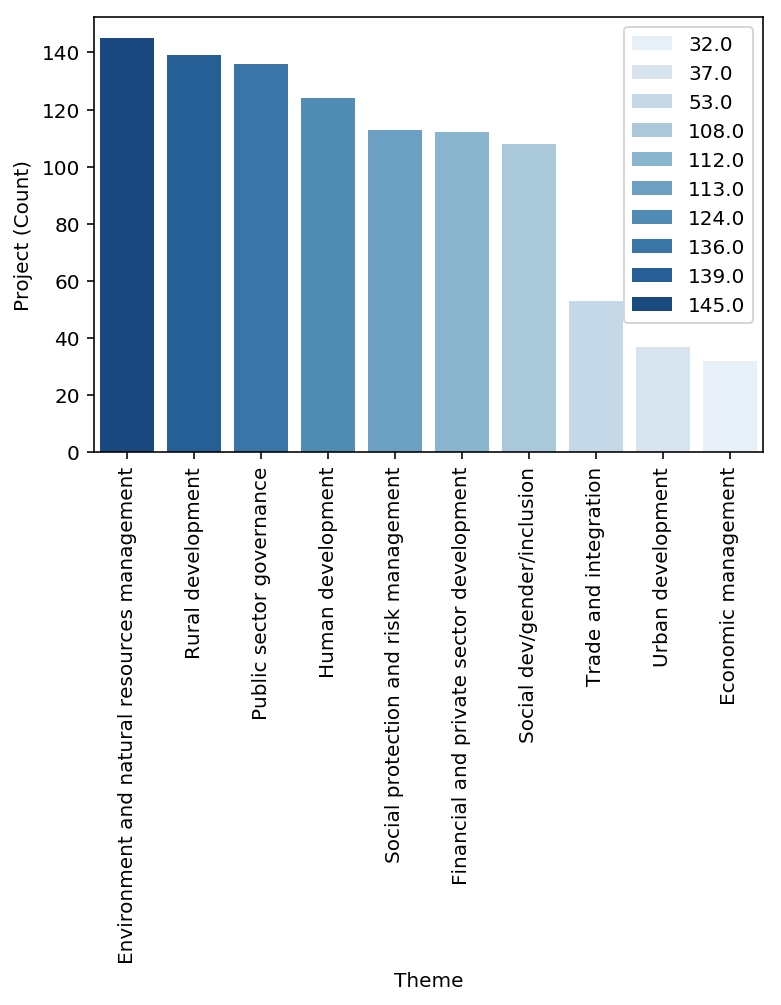

In [13]:
fig, ax = plt.subplots()
g = sns.barplot(data=top10_project_themes_df,ax=ax,y='projects',x='theme_name',hue='projects',dodge=False,palette='Blues')
plt.xticks(rotation=90)
plt.xlabel('Theme')
plt.ylabel('Project (Count)')
plt.legend(loc='upper right')

There's a total of 11 project themes and the most popular themes for projects are in Environmental and Rural Development. On the lower end of the popularity scale are Urban and Economic development projects. We can also see a sharp drop in funded projects between Position 7 and 8, indicating a deprioritization of the positions >=8.

# 3. Fix Column Names

The 'mjtheme_namecode' column contains 'name' keys that are empty despite having been assigned a valid code. This can be fixed with a custom function, which I'll demonstrate below.

In [14]:
# Assign the Worldbank DF to be fixed
df = worldbank_df

# Quick refresher on what our DF looks like
df.head()

,_id,boardapprovaldate,closingdate,countrycode,countryname,regionname,mjtheme_namecode
0,{'$oid': '52b213b38594d8a2be17c780'},2013-11-12,2018-07-07,ET,Federal Democratic Republic of Ethiopia,Africa,"[{'code': '8', 'name': 'Human development'}, {..."
1,{'$oid': '52b213b38594d8a2be17c781'},2013-11-04,NaT,TN,Republic of Tunisia,Middle East and North Africa,"[{'code': '1', 'name': 'Economic management'},..."
2,{'$oid': '52b213b38594d8a2be17c782'},2013-11-01,NaT,TV,Tuvalu,East Asia and Pacific,"[{'code': '5', 'name': 'Trade and integration'..."
3,{'$oid': '52b213b38594d8a2be17c783'},2013-10-31,NaT,RY,Republic of Yemen,Middle East and North Africa,"[{'code': '7', 'name': 'Social dev/gender/incl..."
4,{'$oid': '52b213b38594d8a2be17c784'},2013-10-31,2019-04-30,LS,Kingdom of Lesotho,Africa,"[{'code': '5', 'name': 'Trade and integration'..."


In [15]:
# How Many Missing Names are there?
def count_missing_names(Series):
    """
    Counts occurrences of empty name values in a Series of lists of Theme Dictionaries
    """
    count = 0
    for record in Series:
        for theme in record:
            if len(theme['name']) == 0:
                count += 1
    return count

# Check Number of missing names
num_missing_names = count_missing_names(df.loc[:,'mjtheme_namecode'])
print('There is a total of {} missing names'.format(num_missing_names))      

There is a total of 122 missing names


In [16]:
def fill_names(theme_list):
    """
        Fills in the appropriate value from themes_df corresponding to the theme_code if the value 
        of the 'name' key is empty.
    """
    for theme in theme_list:
        if len(theme['name']) == 0:
            theme['name'] = themes_df.loc[int(theme['code']),'theme_name']
    return theme_list

# Run Custom Function to Fill Empty Names in 'mjtheme_namecode' column
df.loc[:,'mjtheme_namecode'] = df.loc[:,'mjtheme_namecode'].apply(fill_names)

# Check Number of missing names
num_missing_names = count_missing_names(df.loc[:,'mjtheme_namecode'])
print('There is a total of {} missing names'.format(num_missing_names))  

# Make sure that there is no missing values left
assert count_missing_names(df.loc[:,'mjtheme_namecode']) == 0

There is a total of 0 missing names


The *fill_names* function helps to fix the name issue in our worldbank_df and the *count_missing_names* function makes sure we've had a problem that needed fixing in the first place. The latter is also used to test whether our function works using *assert*.

# 4. Projects by Region

In this last part, I'm tackling the regionality of projects to get a better idea of where most of our projects are located and just as important what countries are not pursuing lending projects from the Worldbank.

In [17]:
import os
import geopandas as gpd

To visualize our data we're using shapefiles sources from http://thematicmapping.org/downloads/world_borders.php as well as the DataFrame created for the first task *countries_and_projects_df*.

In [28]:
map_geo = gpd.read_file('shp/TM_WORLD_BORDERS-0.3.shp')
map_geo = map_geo.loc[:,['ISO2','NAME','AREA','POP2005','LON','LAT','geometry']]
map_geo.head(3)

,ISO2,NAME,AREA,POP2005,LON,LAT,geometry
0,AG,Antigua and Barbuda,44,83039,-61.783,17.078,"(POLYGON ((-61.686668 17.02444100000014, -61.7..."
1,DZ,Algeria,238174,32854159,2.632,28.163,"POLYGON ((2.96361 36.802216, 2.981389 36.80693..."
2,AZ,Azerbaijan,8260,8352021,47.395,40.430,(POLYGON ((45.08332100000001 39.76804400000015...


In [20]:
# Some of the Country Codes in the Worldbank data are not ISO 3166-1 alpha-2 conform and need to be updated
countries_and_projects_df_noindex = countries_and_projects_df.reset_index()
update_codes = {'countrycode': dict(zip(['RY','GZ','ZR','TP','YF'],['YE','PS','CG','TL','RS']))}
countries_and_projects_df_noindex = countries_and_projects_df_noindex.replace(update_codes)

projects_iso2_df = countries_and_projects_df_noindex.merge(map_geo.loc[:,['POP2005','AREA','ISO2','LON','LAT','geometry']], 
                                                           how='left', left_on='countrycode',right_on='ISO2')

# Check if there is still unmatched country codes
projects_iso2_df.loc[projects_iso2_df.loc[:,'ISO2'].isnull(),:]

{'countrycode': {'RY': 'YE', 'GZ': 'PS', 'ZR': 'CG', 'TP': 'TL', 'YF': 'RS'}}


,countrycode,countryname,regionname,projects,POP2005,AREA,ISO2,LON,LAT,geometry
55,SS,Republic of South Sudan,Africa,3,NaN,NaN,NaN,NaN,NaN,NaN
79,XK,Republic of Kosovo,Europe and Central Asia,2,NaN,NaN,NaN,NaN,NaN,NaN


Despite the updated country codes to the ISO 3166-1 alpha-2 Standard, South Sudan and Kosovo couldn't be matched in the map data. Since we're only looking at larger trends, I've decided to remove these records as they won't challenge the larger picture.

In [29]:
# Remove remaining null values from projects_iso2_df DataFrame
projects_iso2_df = projects_iso2_df.dropna(subset=['ISO2']).copy()
projects_iso2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 0 to 110
Data columns (total 12 columns):
countrycode           109 non-null object
countryname           109 non-null object
regionname            109 non-null object
projects              109 non-null int64
POP2005               109 non-null float64
AREA                  109 non-null float64
ISO2                  109 non-null object
LON                   109 non-null float64
LAT                   109 non-null float64
geometry              109 non-null object
project_proportion    109 non-null float64
point_geometry        109 non-null object
dtypes: float64(5), int64(1), object(6)
memory usage: 11.1+ KB


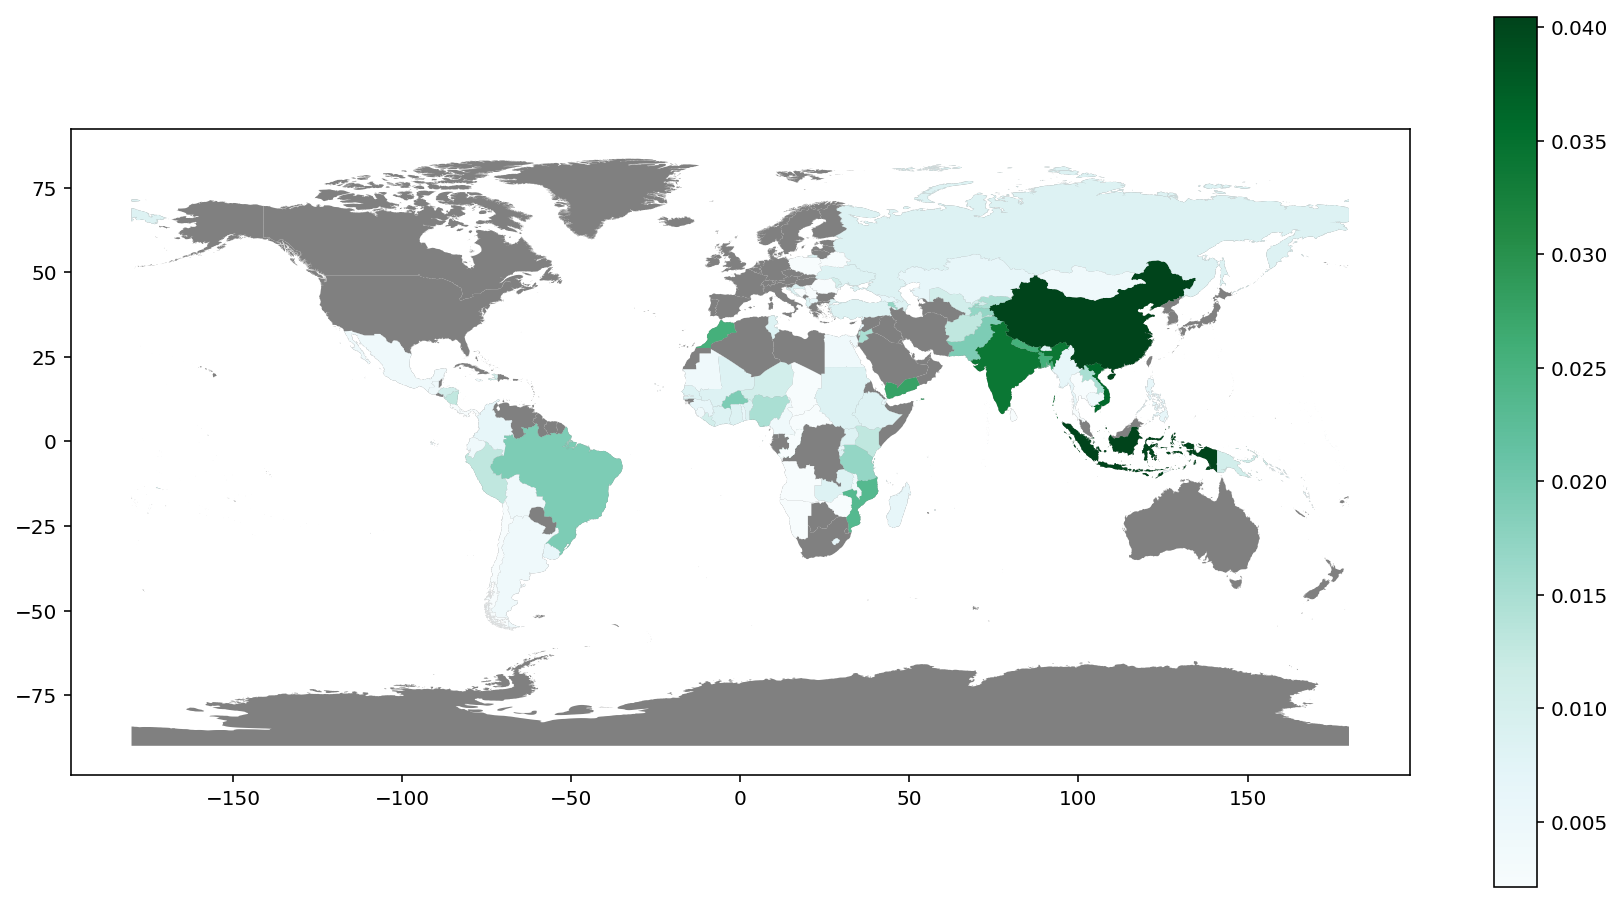

In [24]:
crs = {'init': 'EPSG:3857'}
projects_iso2_chl_gdf = gpd.GeoDataFrame(projects_iso2_df,
                                    crs=crs, geometry=projects_iso2_df['geometry'])

projects_iso2_chl_gdf['project_proportion'] = projects_iso2_chl_gdf.loc[:,['projects']].apply(lambda x: 
                                                    x.projects/projects_iso2_chl_gdf['projects'].sum(),axis='columns')
ax = map_geo.plot(color='gray',figsize=(15,8))
projects_iso2_chl_gdf.plot(ax=ax,column='project_proportion',legend=True,cmap='BuGn')

Proportionally, it's obvious that a large portion of the projects are located in South Asia but other parts of Asia, Latin America and West and East Africa have at least some projects funded by the Worldbank. While this provides a general idea the next graphic will look at this distribution of projects more closely, using a scatter plot.

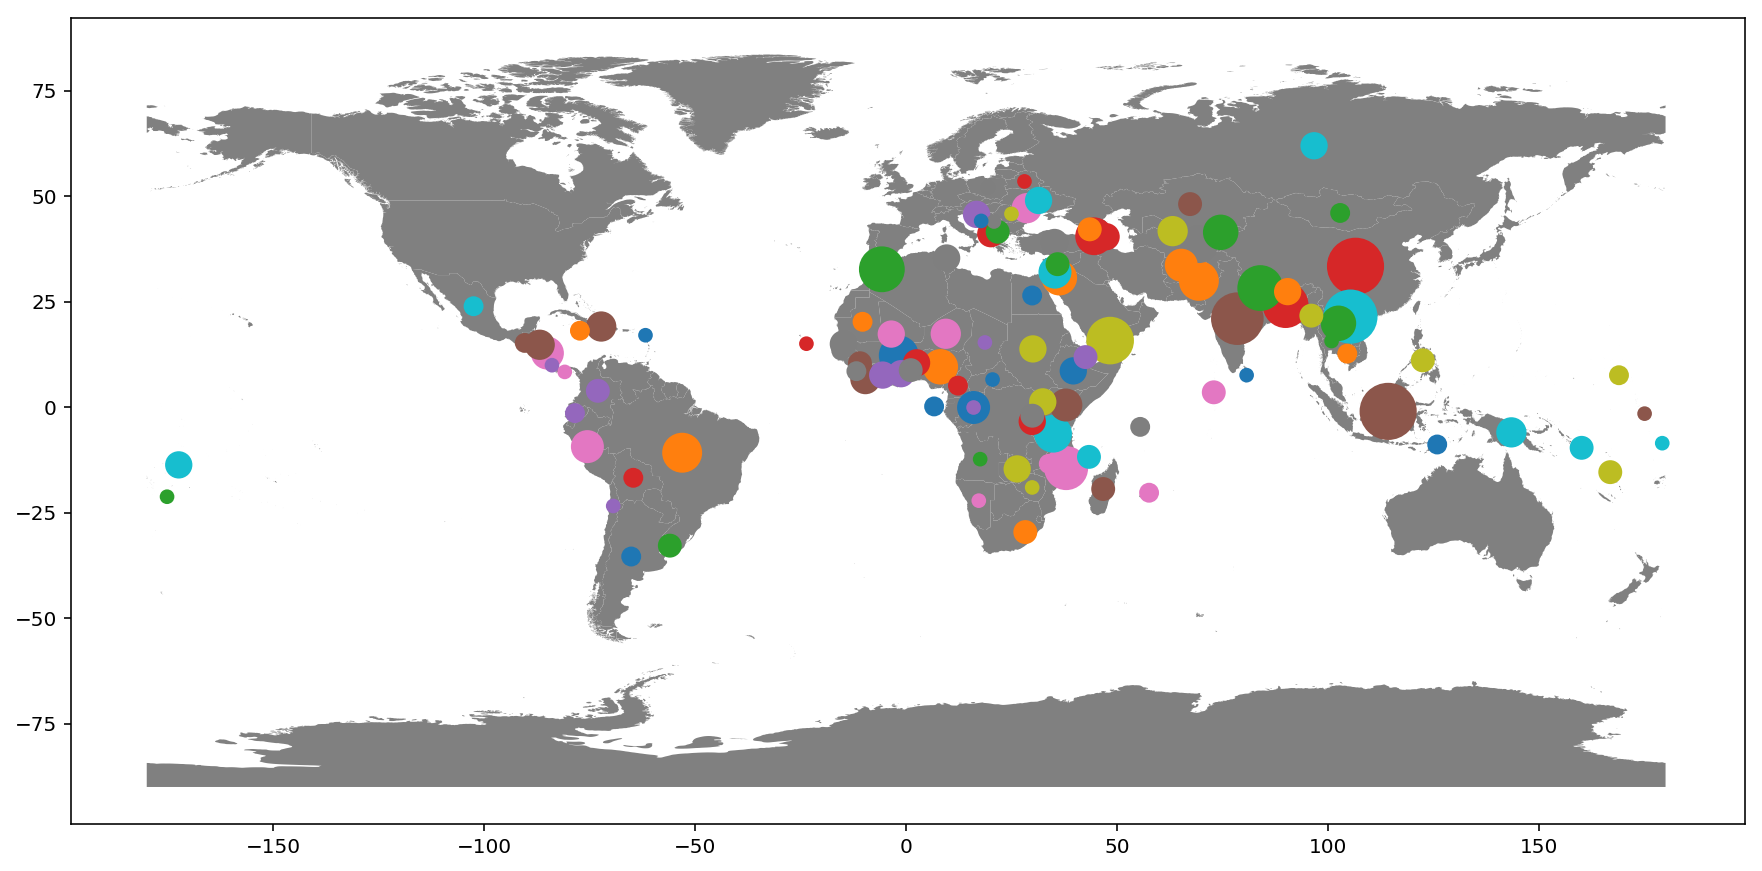

In [30]:
from shapely.geometry import Point

projects_iso2_df['point_geometry'] = projects_iso2_df.apply(lambda rec: Point(float(rec.LON),float(rec.LAT)), axis=1)
crs = {'init': 'EPSG:4326'}
projects_iso2_gdf = gpd.GeoDataFrame(projects_iso2_df,
                                    crs=crs, geometry=projects_iso2_df['point_geometry'])

ax = map_geo.plot(color='gray',figsize=(15,15))
projects_iso2_gdf.plot(ax=ax,column='countryname',s=(projects_iso2_gdf['projects']*40))

This graphic clearly shows that there is a clear band around the Indian Ocean stretching from South East Africa over India, and China all the way to Indonesia. We can also see a second hotspot in West Africa. It would be interesting to see whether the number of projects also correlates with the value of projects and how this would present itself put in contrast with population size. However, for now I'll end my analysis here and call it a day.